# Kaggle Project 7: TMDB Box Office Prediction - Solution
## Prepared by : Dwaipayan Mukherjee (2211569)

## About the project:

In this dataset, we are provided with 7398 movies and a variety of metadata obtained from The Movie Database (TMDB). Movies are labeled with `id`. Data points include cast, crew, plot keywords, budget, posters, release dates, languages, production companies, and countries.

We are predicting the worldwide revenue for 4398 movies in the `test` file.

## Content:


## 1. Imports:

Here I do the necessary imports.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import ast 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.inspection import permutation_importance 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import missingno as msno

In [59]:
from sklearn.model_selection import KFold
import lightgbm
from lightgbm import LGBMRegressor

Now I load the `train` data, `test` data and the `sample_submission` datasets as Pandas DataFrames.

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv("sample_submission.csv")

## 2. Understanding the dataset:

I first check the head of the `train` and `test` datasets, and then the info.

In [4]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [5]:
test.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,...,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,3002,NaN,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."
2,3003,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/97,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de..."
3,3004,NaN,6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,...,"[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",9/4/10,130.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de..."
4,3005,NaN,2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/11/05,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de..."


In [6]:
print("Info of the datasets:\n")
print("\n--------train--------\n")
print(train.info())

print("\n---------test---------\n")
print(test.info())

Info of the datasets:


--------train--------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime  

Descriptive statistics of the numerical columns:

In [8]:
print("Descriptive statistics of the numerical columns:\n")
print("\n--------train--------\n")
print(train.describe().T)

print("\n---------test---------\n")
print(test.describe().T)

Descriptive statistics of the numerical columns:


--------train--------

             count          mean           std       min           25%  \
id          3000.0  1.500500e+03  8.661697e+02  1.000000  7.507500e+02   
budget      3000.0  2.253133e+07  3.702609e+07  0.000000  0.000000e+00   
popularity  3000.0  8.463274e+00  1.210400e+01  0.000001  4.018053e+00   
runtime     2998.0  1.078566e+02  2.208643e+01  0.000000  9.400000e+01   
revenue     3000.0  6.672585e+07  1.375323e+08  1.000000  2.379808e+06   

                     50%           75%           max  
id          1.500500e+03  2.250250e+03  3.000000e+03  
budget      8.000000e+06  2.900000e+07  3.800000e+08  
popularity  7.374861e+00  1.089098e+01  2.943370e+02  
runtime     1.040000e+02  1.180000e+02  3.380000e+02  
revenue     1.680707e+07  6.891920e+07  1.519558e+09  

---------test---------

             count          mean           std          min          25%  \
id          4398.0  5.199500e+03  1.269738e+03  30

## 3. Dealing with Missing Values:

First inspecting the columns for missing values:

In [9]:
print("Missing values\n")

print("\n--------train-----------\n")
print(train.isna().sum())

print("\n--------test----------\n")
print(test.isna().sum())

Missing values


--------train-----------

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

--------test----------

id                          0
belongs_to_collection    3521
budget                      0
genres                     16
homepage                 2978
imdb_id                     0
original_language           0
original_title     

I can differentiate between two groups of columns having missing values: one with maximum values missing and the other with only a small portion missing.

In [11]:
print("Columns with max values missing\n")
print("\n---------train-----------\n")
print(train.columns[train.isna().sum() > (train.shape[0]/2)])

print("\n---------test-----------\n")
print(test.columns[test.isna().sum() > (test.shape[0]/2)])

Columns with max values missing


---------train-----------

Index(['belongs_to_collection', 'homepage'], dtype='object')

---------test-----------

Index(['belongs_to_collection', 'homepage'], dtype='object')


Thus, `belongs_to_collection` and `homepage` are the two columns with over half of the values as missing values.

In [13]:
print("Columns with some values missing\n")
print("\n---------train-----------\n")
print(train.columns[(train.isna().sum() < (train.shape[0]/2)) & (train.isna().sum() != 0)])

print("\n---------test-----------\n")
print(test.columns[(test.isna().sum() < (test.shape[0]/2)) & (test.isna().sum() != 0)])

Columns with some values missing


---------train-----------

Index(['genres', 'overview', 'poster_path', 'production_companies',
       'production_countries', 'runtime', 'spoken_languages', 'tagline',
       'Keywords', 'cast', 'crew'],
      dtype='object')

---------test-----------

Index(['genres', 'overview', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew'],
      dtype='object')


Since the columns `belongs_to_collection` and `homepage` have more than half of its values missing, I will get rid of these two variables from the `train` and the `test` set.

In [14]:
train.drop(['belongs_to_collection', 'homepage'], axis=1, inplace=True)
test.drop(['belongs_to_collection', 'homepage'], axis=1, inplace=True)

Since there are only few missing values in the `runtime` column, I will try to fill them with data from the internet.

In [15]:
train[train['runtime'].isnull()]

,id,budget,genres,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
1335,1336,6000000,"[{'id': 18, 'name': 'Drama'}]",tt1107828,ru,Королёв,NaN,0.292296,/2XcRiIvliLUUGqv5qOvpc76WeCU.jpg,NaN,...,10/29/07,NaN,NaN,Released,NaN,Королёв,NaN,"[{'cast_id': 3, 'character': '–°–µ—Ä–≥–µ–π –ö–...","[{'credit_id': '52fe4db29251416c7513d819', 'de...",31000
2302,2303,0,"[{'id': 35, 'name': 'Comedy'}]",tt0116485,de,Happy Weekend,NaN,0.002229,NaN,"[{'name': 'Senator Film Produktion', 'id': 191}]",...,3/14/96,NaN,"[{'iso_639_1': 'de', 'name': 'Deutsch'}]",Released,NaN,Happy Weekend,"[{'id': 572, 'name': 'sex'}, {'id': 596, 'name...","[{'cast_id': 0, 'character': 'Joachim Krippo',...",NaN,65335


The runtime of the movie named 'Королёв' is 2hrs and 10 mins (i.e., 130 mins), that of 'Happy Weekend'is 1hr and 26 mins (i.e., 86 mins).

In [16]:
train.loc[train['title'] == 'Королёв', 'runtime'] = 130
train.loc[train['title'] == 'Happy Weekend', 'runtime'] = 86

In [17]:
train[train['title'] == 'Happy Weekend']

,id,budget,genres,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
2302,2303,0,"[{'id': 35, 'name': 'Comedy'}]",tt0116485,de,Happy Weekend,NaN,0.002229,NaN,"[{'name': 'Senator Film Produktion', 'id': 191}]",...,3/14/96,86.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}]",Released,NaN,Happy Weekend,"[{'id': 572, 'name': 'sex'}, {'id': 596, 'name...","[{'cast_id': 0, 'character': 'Joachim Krippo',...",NaN,65335


In [18]:
train[train['title'] == 'Королёв']

,id,budget,genres,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
1335,1336,6000000,"[{'id': 18, 'name': 'Drama'}]",tt1107828,ru,Королёв,NaN,0.292296,/2XcRiIvliLUUGqv5qOvpc76WeCU.jpg,NaN,...,10/29/07,130.0,NaN,Released,NaN,Королёв,NaN,"[{'cast_id': 3, 'character': '–°–µ—Ä–≥–µ–π –ö–...","[{'credit_id': '52fe4db29251416c7513d819', 'de...",31000


In [19]:
test[test['runtime'].isnull()]

,id,budget,genres,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
243,3244,0,"[{'id': 35, 'name': 'Comedy'}]",tt0082131,es,La caliente niña Julietta,NaN,0.000464,/6ANZPgGGzplpAUuqx97nmAtmgEH.jpg,"[{'name': 'IFI Producción S.A.', 'id': 16675}]","[{'iso_3166_1': 'ES', 'name': 'Spain'}]",3/20/81,NaN,"[{'iso_639_1': 'es', 'name': 'Español'}]",Released,NaN,La caliente niña Julietta,"[{'id': 293, 'name': 'female nudity'}, {'id': ...","[{'cast_id': 7, 'character': 'Julietta Santigo...","[{'credit_id': '55678cf992514156b600069f', 'de..."
1489,4490,0,"[{'id': 35, 'name': 'Comedy'}]",tt3132094,es,"Pancho, el perro millonario",NaN,0.661399,/h1n1RXda54WmuFmrcPU7iXZN0ta.jpg,"[{'name': 'Atresmedia Cine', 'id': 29566}, {'n...","[{'iso_3166_1': 'ES', 'name': 'Spain'}]",6/6/14,NaN,"[{'iso_639_1': 'es', 'name': 'Español'}]",Released,NaN,"Pancho, el perro millonario","[{'id': 11493, 'name': 'animal as human'}, {'i...","[{'cast_id': 3, 'character': 'Alberto', 'credi...","[{'credit_id': '52fe4e1c9251416c91126d43', 'de..."
1632,4633,0,"[{'id': 35, 'name': 'Comedy'}]",tt0078010,es,Nunca en horas de clase,NaN,0.281500,/wVDY6zJV5GCkZF07CMYE8s37Rx7.jpg,"[{'name': 'Films Zodíaco', 'id': 36421}]","[{'iso_3166_1': 'ES', 'name': 'Spain'}]",11/3/78,NaN,"[{'iso_639_1': 'es', 'name': 'Español'}]",Released,NaN,Nunca en horas de clase,"[{'id': 107, 'name': 'barcelona spain'}, {'id'...","[{'cast_id': 6, 'character': 'Susy', 'credit_i...","[{'credit_id': '544d2dd20e0a2608c2002879', 'de..."
3817,6818,0,NaN,tt2192844,fi,Miesten välisiä keskusteluja,NaN,0.011427,/iGykvX2LgYFz9EKAjqGoni9xmCf.jpg,"[{'name': 'Vegetarian Films', 'id': 80999}]","[{'iso_3166_1': 'FI', 'name': 'Finland'}]",1/4/13,NaN,"[{'iso_639_1': 'fi', 'name': 'suomi'}]",Released,NaN,Miesten välisiä keskusteluja,NaN,"[{'cast_id': 0, 'character': 'Kari Mairisaari'...","[{'credit_id': '57cad03a9251411ac50030a1', 'de..."


The `runtime` for the movies are as follows:
* La caliente niña Julietta = 93 mins
* Pancho, el perro millonario = 91 mins
* Nunca en horas de clase = 100 mins
* Miesten välisiä keskusteluja	= 90 mins

In [20]:
test.loc[test['title'] == 'La caliente niña Julietta', 'runtime'] = 93
test.loc[test['title'] == 'Pancho, el perro millonario', 'runtime'] = 91
test.loc[test['title'] == 'Nunca en horas de clase', 'runtime'] = 100
test.loc[test['title'] == 'Miesten välisiä keskusteluja', 'runtime'] = 90

In [21]:
test[test['runtime'].isnull()]

,id,budget,genres,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew


In [22]:
train[train['runtime'].isnull()]

,id,budget,genres,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue


Since there is only one missing value in the `release_date` column in the test data, I will fill that from the internet as well.

In [23]:
test[test["release_date"].isnull()]

,id,budget,genres,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
828,3829,0,"[{'id': 18, 'name': 'Drama'}]",tt0210130,en,"Jails, Hospitals & Hip-Hop","Jails, Hospitals &amp; Hip-Hop is a cinematic ...",0.009057,NaN,NaN,NaN,NaN,90.0,NaN,NaN,three worlds / two million voices / one genera...,"Jails, Hospitals & Hip-Hop",NaN,[],NaN


The release date for this film was 05.01.2000.

In [24]:
test.loc[test['release_date'].isnull()==True, 'release_date']= '5/1/00'
test[test["release_date"]== '5/1/00']

,id,budget,genres,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
828,3829,0,"[{'id': 18, 'name': 'Drama'}]",tt0210130,en,"Jails, Hospitals & Hip-Hop","Jails, Hospitals &amp; Hip-Hop is a cinematic ...",0.009057,NaN,NaN,NaN,5/1/00,90.0,NaN,NaN,three worlds / two million voices / one genera...,"Jails, Hospitals & Hip-Hop",NaN,[],NaN
1731,4732,103000000,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",tt0172495,en,Gladiator,"In the year 180, the death of emperor Marcus A...",23.186667,/6WBIzCgmDCYrqh64yDREGeDk9d3.jpg,"[{'name': 'DreamWorks SKG', 'id': 27}, {'name'...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",5/1/00,155.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Hero Will Rise.,Gladiator,"[{'id': 588, 'name': 'rome'}, {'id': 1394, 'na...","[{'cast_id': 8, 'character': 'Maximus', 'credi...","[{'credit_id': '52fe4217c3a36847f800340d', 'de..."


For nominal data columns, I am filling the null values with "none".

In [25]:
train[['genres',
       'spoken_languages', 
       'status', 
       'production_countries', 
       'production_companies', 
       'cast',
       'crew']] = train[['genres',
         'spoken_languages',
         'status', 
         'production_countries',
         'production_companies', 
         'cast',
         'crew']].fillna("none")

test[['genres',
       'spoken_languages', 
       'status', 
       'production_countries', 
       'production_companies', 
       'cast',
       'crew']] = test[['genres',
         'spoken_languages',
         'status', 
         'production_countries',
         'production_companies', 
         'cast',
         'crew']].fillna("none")

In [26]:
train.isna().sum()

id                        0
budget                    0
genres                    0
imdb_id                   0
original_language         0
original_title            0
overview                  8
popularity                0
poster_path               1
production_companies      0
production_countries      0
release_date              0
runtime                   0
spoken_languages          0
status                    0
tagline                 597
title                     0
Keywords                276
cast                      0
crew                      0
revenue                   0
dtype: int64

In [27]:
test.isna().sum()

id                        0
budget                    0
genres                    0
imdb_id                   0
original_language         0
original_title            0
overview                 14
popularity                0
poster_path               1
production_companies      0
production_countries      0
release_date              0
runtime                   0
spoken_languages          0
status                    0
tagline                 863
title                     3
Keywords                393
cast                      0
crew                      0
dtype: int64

The only missing values now are in the columns `overview`, `poster_path`, `tagline` and `Keywords`. However, since I am not going to use them for the Box Office revenue predictions, I will leave those at they are.

## 4. Formatting the dates:

Converting the dates in datetime format and creating new columns named `release_year`, `release_month` and `release_day`.

In [28]:
train['release_date'] = pd.to_datetime(train['release_date'], format='%m/%d/%y')
test['release_date'] = pd.to_datetime(test['release_date'], format='%m/%d/%y')

train["release_year"] = pd.to_datetime(train["release_date"]).dt.year.astype(int)
train["release_day"] = pd.to_datetime(train["release_date"]).dt.dayofweek.astype(int)
train["release_month"] = pd.to_datetime(train["release_date"]).dt.month.astype(int)
test["release_year"] = pd.to_datetime(test["release_date"]).dt.year.astype(int)
test["release_day"] = pd.to_datetime(test["release_date"]).dt.dayofweek.astype(int)
test["release_month"] = pd.to_datetime(test["release_date"]).dt.month.astype(int)

In [29]:
train['release_year'].max()

2068

Since this competition was released in the year 2019, there should not be any date of release after 2019. 

In [30]:
# Fixing the dates
def fix_date(x):
    if x > 2019:
        return x - 100
    else:
        return x 

train['release_year'] = train['release_year'].apply(lambda x: fix_date(x))
test['release_year'] = test['release_year'].apply(lambda x: fix_date(x))

In [31]:
train['release_year'].max()

2017

Now this is alright!!

## 5. Exploratory Data Analysis:

First I look at the `revenue`:

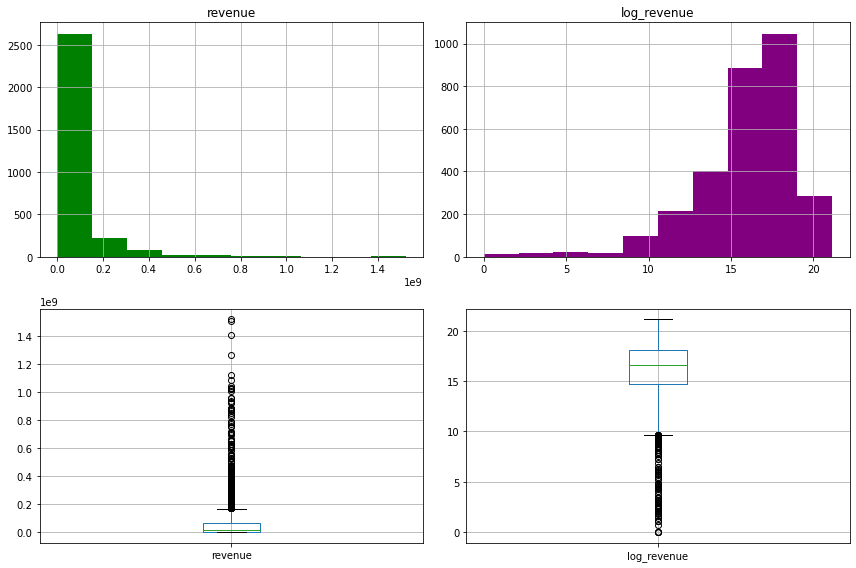

In [32]:
train['log_revenue'] = np.log(train['revenue'])

fig, ax = plt.subplots(2, 2, figsize = (12, 8), tight_layout=True)
train.hist(column= ["revenue"], ax=ax[0][0], color='green')
train.hist(column= ['log_revenue'], ax=ax[0][1], color='purple')
train.boxplot(column= ["revenue"], ax=ax[1][0])
train.boxplot(column= ['log_revenue'], ax=ax[1][1])

Next, I explore `budget` and `popularity`:

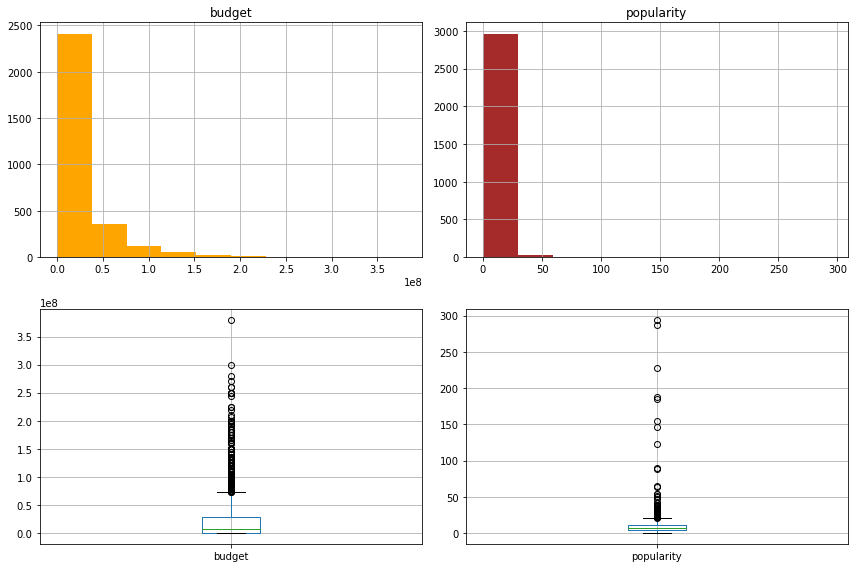

In [33]:
fig, ax = plt.subplots(2, 2, figsize = (12, 8), tight_layout=True)
train.hist(column= ["budget"], ax=ax[0][0], color='orange')
train.hist(column= ['popularity'], ax=ax[0][1], color='brown')
train.boxplot(column= ['budget'], ax=ax[1][0])
train.boxplot(column= ['popularity'], ax=ax[1][1])

Next, I look into the `runtime` and the `release_year`:

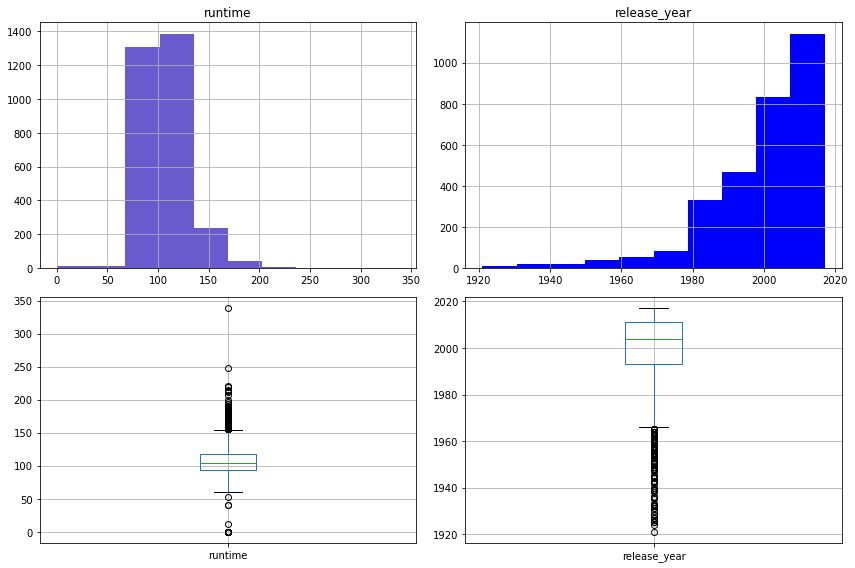

In [34]:
fig, ax = plt.subplots(2, 2, figsize = (12, 8), tight_layout=True)
train.hist(column= ["runtime"], ax=ax[0][0], color='slateblue')
train.hist(column= ['release_year'], ax=ax[0][1], color='blue')
train.boxplot(column= ['runtime'], ax=ax[1][0])
train.boxplot(column= ['release_year'], ax=ax[1][1])

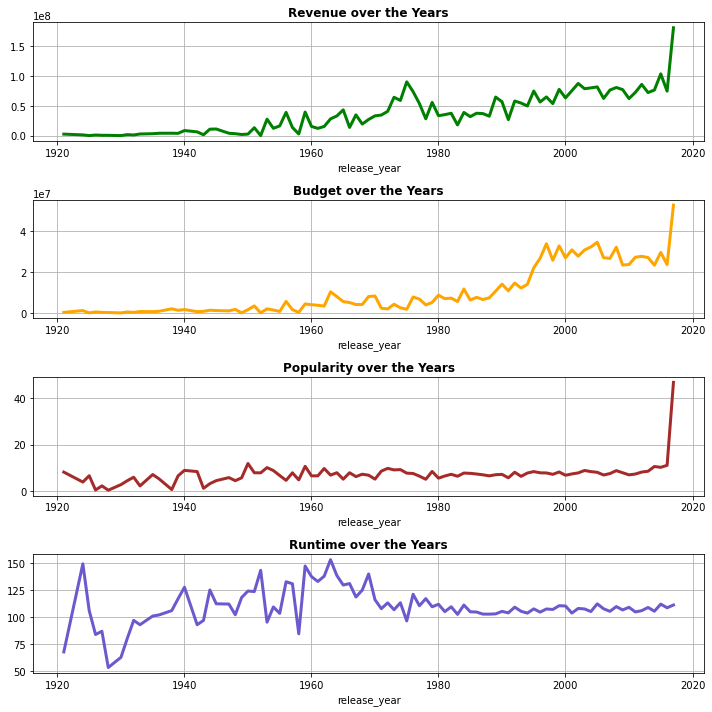

In [35]:
fig, ax = plt.subplots(4, 1, tight_layout=True)
plt.grid()

train.groupby('release_year')['revenue'].mean().plot(ax=ax[0], figsize=(10, 10), linewidth=3, color='green').set_title('Revenue over the Years', fontweight="bold")
ax[0].grid()

train.groupby('release_year')['budget'].mean().plot(ax=ax[1], figsize=(10, 10), linewidth=3, color='orange').set_title('Budget over the Years', fontweight="bold")
ax[1].grid()

train.groupby('release_year')['popularity'].mean().plot(ax=ax[2], figsize=(10, 10), linewidth=3, color='brown').set_title('Popularity over the Years', fontweight="bold")
ax[2].grid()

train.groupby('release_year')['runtime'].mean().plot(ax=ax[3], figsize=(10, 10), linewidth=3, color='slateblue').set_title('Runtime over the Years', fontweight="bold")
ax[3].grid()

fig.tight_layout(pad=2.0)
plt.show()

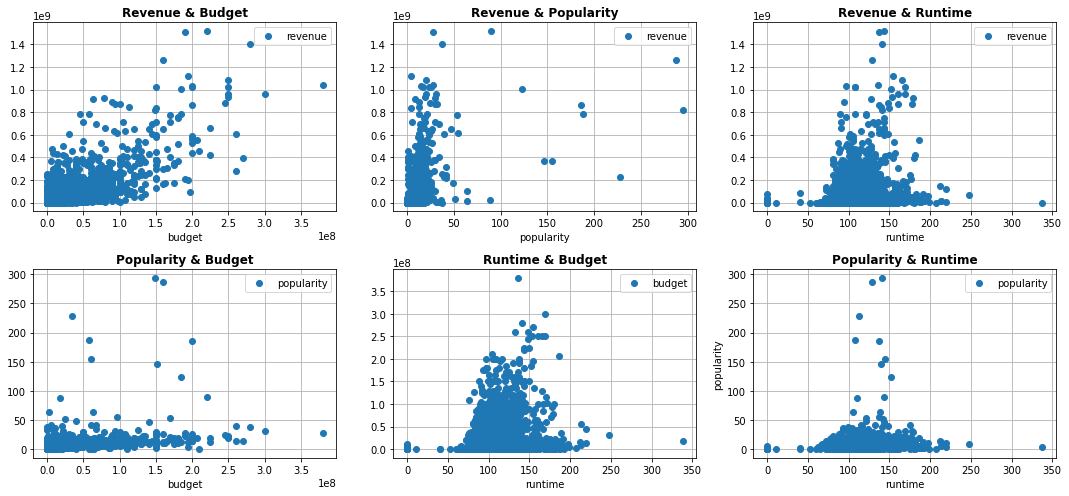

In [41]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7), tight_layout=True)

train.plot(ax=ax[0][0], x='budget', y='revenue', style='o', colormap='GnBu').set_title('Revenue & Budget', fontweight="bold")
ax[0][0].grid()
plt.ylabel('revenue')

train.plot(ax=ax[0][1], x='popularity', y='revenue', style='o').set_title('Revenue & Popularity', fontweight="bold")
ax[0][1].grid()
plt.ylabel('revenue')

train.plot(ax=ax[0][2], x='runtime', y='revenue', style='o', colormap='BrBG').set_title('Revenue & Runtime', fontweight="bold")
ax[0][2].grid()
plt.ylabel('revenue')

train.plot(ax=ax[1][0], x='budget', y='popularity', style='o', colormap='ocean').set_title('Popularity & Budget', fontweight="bold")
ax[1][0].grid()
plt.ylabel('popularity')

train.plot(ax=ax[1][1], x='runtime', y='budget', style='o', colormap='coolwarm').set_title('Runtime & Budget', fontweight="bold")
ax[1][1].grid()
plt.ylabel('budget')

train.plot(ax=ax[1][2], x='runtime', y='popularity', style='o', colormap='viridis').set_title('Popularity & Runtime', fontweight="bold")
ax[1][2].grid()
plt.ylabel('popularity')

fig.tight_layout(pad=4.0)
plt.show()

## 6. Feature Engineering:

Many features are in JSON format. First, I convert the features in JSON format to nominal format. Then, I am counting the occurances in those features which I plan to use in the model, unless they are not redundant.

In [42]:
for e in enumerate(test['genres'][:10]):
    print(e)

(0, "[{'id': 12, 'name': 'Adventure'}, {'id': 16, 'name': 'Animation'}, {'id': 10751, 'name': 'Family'}, {'id': 14, 'name': 'Fantasy'}]")
(1, "[{'id': 27, 'name': 'Horror'}, {'id': 878, 'name': 'Science Fiction'}]")
(2, "[{'id': 35, 'name': 'Comedy'}, {'id': 10749, 'name': 'Romance'}]")
(3, "[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'name': 'War'}, {'id': 9648, 'name': 'Mystery'}]")
(4, "[{'id': 36, 'name': 'History'}, {'id': 99, 'name': 'Documentary'}]")
(5, "[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}]")
(6, "[{'id': 10749, 'name': 'Romance'}, {'id': 18, 'name': 'Drama'}, {'id': 35, 'name': 'Comedy'}]")
(7, "[{'id': 16, 'name': 'Animation'}, {'id': 10751, 'name': 'Family'}]")
(8, "[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]")
(9, "[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]")


In [43]:
def get_dictionary(s):
    try:
        d = eval(s)
    except:
        d = {}
    return d

In [44]:
train.genres = train.genres.map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))
train.spoken_languages = train.spoken_languages.map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))
train.cast = train.cast.map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))
train.crew = train.crew.map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))

test.genres = test.genres.map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))
test.spoken_languages = test.spoken_languages.map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))
test.cast = test.cast.map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))
test.crew = test.crew.map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))

train.crew.head()

0    Adam Blum,Allison Gordin,Andrew Panay,Annabell...
1    Bruce Green,Charles Minsky,Debra Martin Chase,...
2    Alicia Hadaway,Andy Ross,Barbara Harris,Ben Wi...
3                  Sujoy Ghosh,Sujoy Ghosh,Sujoy Ghosh
4                        Jong-seok Yoon,Jong-seok Yoon
Name: crew, dtype: object

In [45]:
train['genres_count'] = train['genres'].str.count(',') + 1
train['spoken_languages_count'] = train['spoken_languages'].str.count(',') + 1
train['cast_count'] = train['cast'].str.count(',') + 1
train['crew_count'] = train['crew'].str.count(',') + 1

test['genres_count'] = test['genres'].str.count(',') + 1
test['spoken_languages_count'] = test['spoken_languages'].str.count(',') + 1
test['cast_count'] = test['cast'].str.count(',') + 1
test['crew_count'] = test['crew'].str.count(',') + 1
test['genres_count']

0       4
1       2
2       2
3       3
4       2
       ..
4393    1
4394    4
4395    1
4396    2
4397    1
Name: genres_count, Length: 4398, dtype: int64

Converting nominal data to numerical:

In [46]:
train[['status', 
      'original_language', 
      'production_companies', 
      'production_countries']] = train[['status', 
               'original_language', 
               'production_companies',
               'production_countries']].astype('category')

train['status'] = train['status'].cat.codes
train['original_language'] = train['original_language'].cat.codes
train['production_companies'] = train['production_companies'].cat.codes
train['production_countries'] = train['production_countries'].cat.codes

test[['status', 
      'original_language', 
      'production_companies', 
      'production_countries']] = test[['status', 
               'original_language', 
               'production_companies',
               'production_countries']].astype('category')

test['status'] = test['status'].cat.codes
test['original_language'] = test['original_language'].cat.codes
test['production_companies'] = test['production_companies'].cat.codes
test['production_countries'] = test['production_countries'].cat.codes

train['production_countries']

0       316
1       316
2       316
3       210
4       236
       ... 
2995    316
2996    111
2997    316
2998    316
2999    316
Name: production_countries, Length: 3000, dtype: int16

Budget has zero values for many movies including some high budget movies. Additionally, it does not make sense to have movies with 0 runtimes. 

So, I am imputing those zero values with mean.

In [47]:
train['budget'] = train['budget'].replace(0, train['budget'].mean())  
train['runtime'] = train['runtime'].replace(0, train['runtime'].mean())  

test['budget'] = test['budget'].replace(0, test['budget'].mean())  
test['runtime'] = test['runtime'].replace(0, test['runtime'].mean())  

## 7. Preparing the data for model fitting:

First I separate out the target and the feature columns.

In [48]:
y = train['log_revenue']
X = train.drop(['log_revenue', 'revenue'], axis=1)

In [50]:
# Creating the list of features
feature_names = ['release_year', 'release_day', 'release_month', 'status', 'original_language',
                 'budget', 'popularity', 'genres_count', 'production_companies', 'production_countries',
                'spoken_languages_count', 'cast_count', 'crew_count', 'runtime']

In [51]:
X_feat = X[feature_names]

## 8. Modelling:

### 8.1 Random Forest model:

In [52]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)
rf_err = []

for i, (train_index, val_index) in enumerate(kf.split(train)):
    X_train, X_val = X_feat.loc[train_index], X_feat.loc[val_index]
    y_train, y_val = y.loc[train_index], y.loc[val_index]
    
    ## Random forest model
    rf_model = RandomForestRegressor(n_estimators = 100, random_state = 1)
    
    ## Fitting the model:
    rf_model.fit(X_train, y_train)
    
    ## Model prediction:
    rf_pred = rf_model.predict(X_val)
    
    ## Model Evaluation:
    rf_mae = mean_absolute_error(y_val, rf_pred)
    print(f"Fold {i+1}: MAE = {rf_mae}")
    rf_err.append(rf_mae)
    
print("Average MAE from RF model = ", np.mean(rf_mae))

Fold 1: MAE = 1.3529269477147203
Fold 2: MAE = 1.335235956155954
Fold 3: MAE = 1.314054298483006
Fold 4: MAE = 1.4291252480025518
Fold 5: MAE = 1.3890576226072453
Fold 6: MAE = 1.2889085395419988
Fold 7: MAE = 1.5539389151825818
Fold 8: MAE = 1.5007365306559148
Fold 9: MAE = 1.514624060494875
Fold 10: MAE = 1.432852871539571
Average MAE from RF model =  1.432852871539571


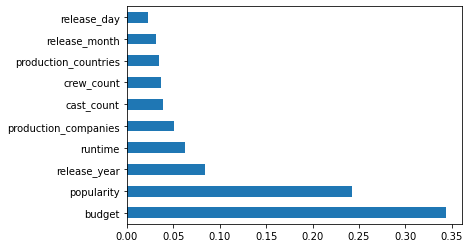

In [53]:
# Calculating feature importance
feat_importances = pd.Series(rf_model.feature_importances_, index=X_feat.columns)
feat_importances.nlargest(10).plot(kind='barh')

### 8.2 XGBoost Model:

In [55]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)
xgb_err = []

for i, (train_index, val_index) in enumerate(kf.split(train)):
    X_train, X_val = X_feat.loc[train_index], X_feat.loc[val_index]
    y_train, y_val = y.loc[train_index], y.loc[val_index]
    
    ## XGBoost model
    xgb_model = XGBRegressor(n_estimators = 200,
                             max_depth = 9,
                             learning_rate = 0.01,
                             colsample_bytree = 0.7,
                             subsample = 0.8,
                             random_state = 1)
    
    ## Fitting the model:
    xgb_model.fit(X_train, y_train)
    
    ## Model prediction:
    xgb_pred = xgb_model.predict(X_val)
    
    ## Model Evaluation:
    xgb_mae = mean_absolute_error(y_val, xgb_pred)
    print(f"Fold {i+1}: MAE = {xgb_mae}")
    xgb_err.append(xgb_mae)
    
print("Average MAE from XGBoost model = ", np.mean(xgb_mae))

Fold 1: MAE = 2.683043079000712
Fold 2: MAE = 2.502387098249896
Fold 3: MAE = 2.618024908367063
Fold 4: MAE = 2.562489799519476
Fold 5: MAE = 2.721297261828958
Fold 6: MAE = 2.5640164071276246
Fold 7: MAE = 2.853337451609376
Fold 8: MAE = 2.664484773300827
Fold 9: MAE = 2.7268057792995397
Fold 10: MAE = 2.821547595965816
Average MAE from XGBoost model =  2.821547595965816


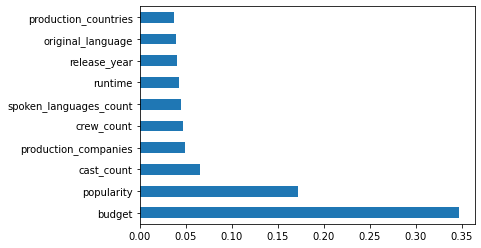

In [56]:
# Calculating feature importance
feat_importances = pd.Series(xgb_model.feature_importances_, index=X_feat.columns)
feat_importances.nlargest(10).plot(kind='barh')

### 8.3 LightGBM model:

In [60]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)
lgb_err = []

for i, (train_index, val_index) in enumerate(kf.split(train)):
    X_train, X_val = X_feat.loc[train_index], X_feat.loc[val_index]
    y_train, y_val = y.loc[train_index], y.loc[val_index]
    
    ## Light GBM model
    lgb_model = LGBMRegressor(learning_rate=0.01,
                          max_depth=9,
                          num_leaves=90,
                          colsample_bytree=0.8,
                          subsample=0.9,
                          subsample_freq=5,
                          min_child_samples=36,
                          reg_lambda=28,
                          n_estimators=200,
                          metric='mae',
                          random_state=1)
    
    ## Fitting the model:
    lgb_model.fit(X_train.values,
                  y_train,
                  early_stopping_rounds=100,
                  eval_set = [(X_val.values, y_val)],
                  callbacks=[lightgbm.early_stopping(100, verbose=True)])
    
    ## Model prediction:
    lgb_pred = lgb_model.predict(X_val)
    
    ## Model Evaluation:
    lgb_mae = mean_absolute_error(y_val, lgb_pred)
    print(f"Fold {i+1}: MAE = {lgb_mae}")
    lgb_err.append(lgb_mae)
    
print("Average MAE from Light GBM model = ", np.mean(lgb_mae))

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
Fold 1: MAE = 1.4498781303506598
Training until validation scores don't improve for 100 rounds


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


Did not meet early stopping. Best iteration is:
[200]	valid_0's l1: 1.49136
Fold 2: MAE = 1.4913570371954772
Training until validation scores don't improve for 100 rounds


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


Did not meet early stopping. Best iteration is:
[200]	valid_0's l1: 1.37195
Fold 3: MAE = 1.3719459522548494
Training until validation scores don't improve for 100 rounds


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


Did not meet early stopping. Best iteration is:
[200]	valid_0's l1: 1.48013
Fold 4: MAE = 1.4801265791998535
Training until validation scores don't improve for 100 rounds


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


Did not meet early stopping. Best iteration is:
[200]	valid_0's l1: 1.48232
Fold 5: MAE = 1.4823204795995022
Training until validation scores don't improve for 100 rounds


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


Did not meet early stopping. Best iteration is:
[200]	valid_0's l1: 1.31379
Fold 6: MAE = 1.3137871564462393
Training until validation scores don't improve for 100 rounds


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


Did not meet early stopping. Best iteration is:
[200]	valid_0's l1: 1.5717
Fold 7: MAE = 1.5717026369254286
Training until validation scores don't improve for 100 rounds


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


Did not meet early stopping. Best iteration is:
[200]	valid_0's l1: 1.59673
Fold 8: MAE = 1.596725962718311
Training until validation scores don't improve for 100 rounds


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


Did not meet early stopping. Best iteration is:
[200]	valid_0's l1: 1.54562
Fold 9: MAE = 1.5456199999202376
Training until validation scores don't improve for 100 rounds


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


Did not meet early stopping. Best iteration is:
[200]	valid_0's l1: 1.43471
Fold 10: MAE = 1.4347145279119586
Average MAE from Light GBM model =  1.4347145279119586


## 9. Final Prediction on test set:

Since the Random Forest Regressor performs best among the three models I have tried, I will be using it for the final prediction on the test set.

In [61]:
X = train[feature_names]
X_test = test[feature_names]

In [62]:
final_model = RandomForestRegressor(n_estimators = 100, random_state = 1)

final_model.fit(X, y)

RandomForestRegressor(random_state=1)

In [63]:
y_pred_final = final_model.predict(X_test)
pred = pd.DataFrame(y_pred_final)

In [64]:
datasets = pd.concat([submission['id'], pred], axis=1)
datasets.columns =['id', 'revenue']
datasets.to_csv('submission.csv', index=False)